In [ ]:
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

from diffdeb.config import get_config_LDM
from diffdeb.diffusion import backward_denoising_ddpm
from diffdeb.load_weights import load_model_weights
from diffdeb.models import Decoder, Encoder, UNet

# from flax.training import orbax_utils

In [ ]:
rng = random.key(42)
config = get_config_LDM()

In [ ]:
encoder_model = encoder_model = Encoder(
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.encoder_filters,
    kernels=config.vae_config.encoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
decoder_model = Decoder(
    input_shape=config.vae_config.input_shape,
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.decoder_filters,
    kernels=config.vae_config.decoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
rng, key = random.split(rng)
UNet_model = UNet().init(key, (jnp.ones((1, 12, 12, 2)), jnp.ones(1)))

# Load dataset for initial testing

In [ ]:
encoder_params = load_model_weights(config.vae_config)["encoder"]
decoder_params = load_model_weights(config.vae_config)["decoder"]
vae_params = load_model_weights(config.vae_config)

UNet_pararms = load_model_weights(config.diffusion_config)

Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet and step 103


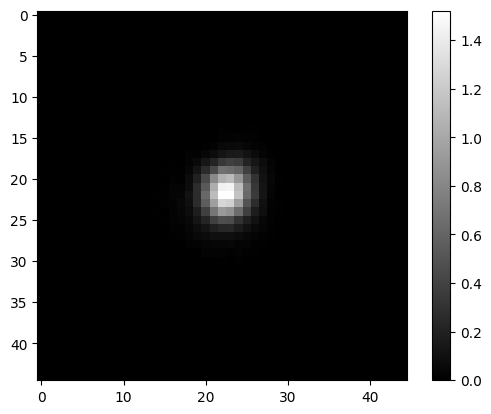

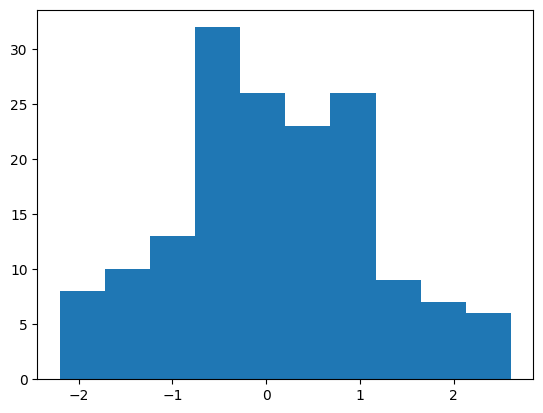

TIMESTEP: 499
TIMESTEP: 498
TIMESTEP: 497
TIMESTEP: 496
TIMESTEP: 495
TIMESTEP: 494
TIMESTEP: 493
TIMESTEP: 492
TIMESTEP: 491
TIMESTEP: 490
TIMESTEP: 489
TIMESTEP: 488
TIMESTEP: 487
TIMESTEP: 486
TIMESTEP: 485
TIMESTEP: 484
TIMESTEP: 483
TIMESTEP: 482
TIMESTEP: 481
TIMESTEP: 480
TIMESTEP: 479
TIMESTEP: 478
TIMESTEP: 477
TIMESTEP: 476
TIMESTEP: 475
TIMESTEP: 474
TIMESTEP: 473
TIMESTEP: 472
TIMESTEP: 471
TIMESTEP: 470
TIMESTEP: 469
TIMESTEP: 468
TIMESTEP: 467
TIMESTEP: 466
TIMESTEP: 465
TIMESTEP: 464
TIMESTEP: 463
TIMESTEP: 462
TIMESTEP: 461
TIMESTEP: 460
TIMESTEP: 459
TIMESTEP: 458
TIMESTEP: 457
TIMESTEP: 456
TIMESTEP: 455
TIMESTEP: 454
TIMESTEP: 453
TIMESTEP: 452
TIMESTEP: 451
TIMESTEP: 450
TIMESTEP: 449
TIMESTEP: 448
TIMESTEP: 447
TIMESTEP: 446
TIMESTEP: 445
TIMESTEP: 444
TIMESTEP: 443
TIMESTEP: 442
TIMESTEP: 441
TIMESTEP: 440
TIMESTEP: 439
TIMESTEP: 438
TIMESTEP: 437
TIMESTEP: 436
TIMESTEP: 435
TIMESTEP: 434
TIMESTEP: 433
TIMESTEP: 432
TIMESTEP: 431
TIMESTEP: 430
TIMESTEP: 429
TIMEST

In [ ]:
# Generating Gaussian noise
rng, key = random.split(rng)
x = random.normal(key=key, shape=(10, 16, 1))
timesteps = 500

# Create a list to store output images
img_list_ddpm = []

# Append the initial noise to the list of images
im = decoder_model.apply({"params": decoder_params}, x[:, :, 0])
# print(im)
# img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

plt.imshow(im[0, :, :, 2], cmap="gray")
plt.colorbar()
plt.show()


plt.hist(x.flatten())
plt.show()

rng, key = random.split(rng)

# Iterate over T timesteps
for i in range(0, timesteps - 1):
    # t-th timestep
    prev_x = x
    subkey = jax.random.fold_in(rng, i)
    t = jnp.expand_dims(jnp.array(timesteps - i - 1, jnp.int32), 0)

    # Predict noise using U-Net
    noise = UNet().apply({"params": UNet_pararms}, (x, t))

    rng, key = random.split(rng)
    x = backward_denoising_ddpm(subkey, x, noise, t)

    if i % 25 == 0:
        plt.hist(x.flatten())
        plt.show()

    print("TIMESTEP: " + str(timesteps - i - 1))

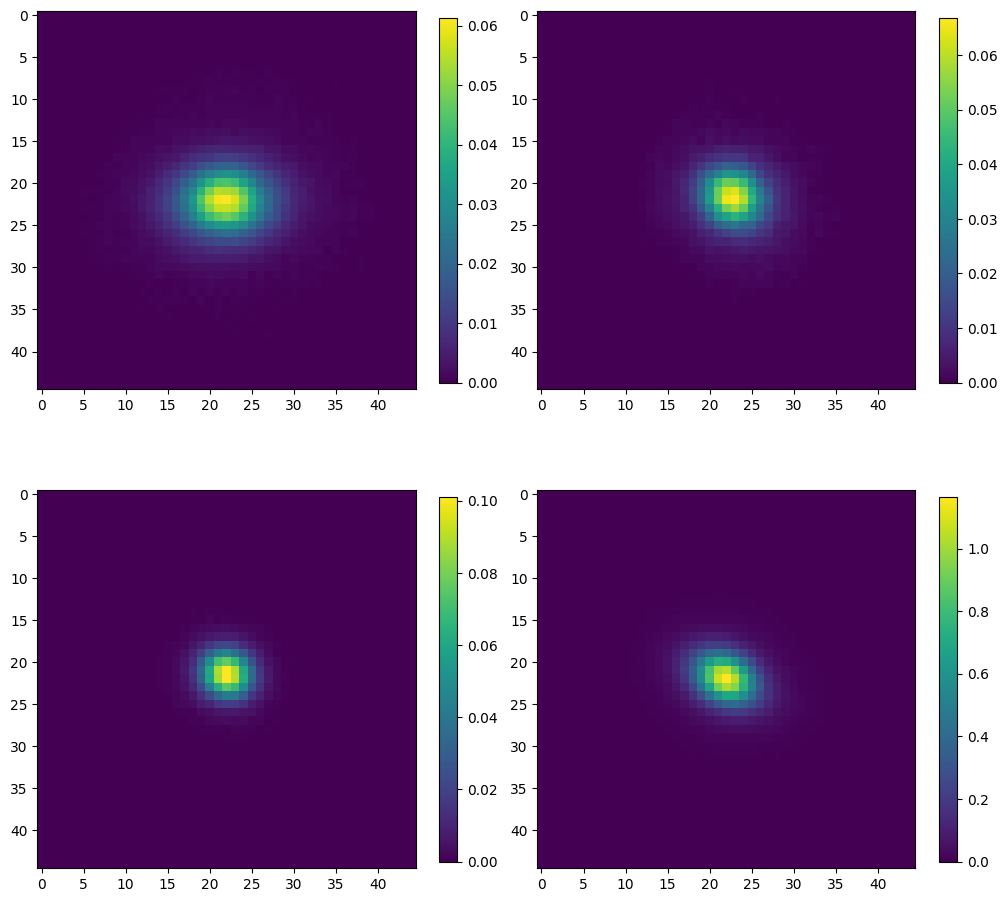

In [ ]:
filt_num = 2
sim_galaxy_images = decoder_model.apply({"params": decoder_params}, x[:, :, 0])
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

im = axs[0][0].imshow(sim_galaxy_images[0, :, :, filt_num])
fig.colorbar(im, shrink=0.7)

im = axs[0][1].imshow(sim_galaxy_images[1, :, :, filt_num])
fig.colorbar(im, shrink=0.7)

im = axs[1][0].imshow(sim_galaxy_images[2, :, :, filt_num])
fig.colorbar(im, shrink=0.7)

im = axs[1][1].imshow(sim_galaxy_images[3, :, :, filt_num])
fig.colorbar(im, shrink=0.7)

plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", "sampling-results.pdf"),
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
beta1 = jnp.linspace(0.0001, 0.05, 500)
alpha1 = 1 - beta1
alpha_bar1 = jnp.cumprod(alpha1, 0)
alpha_bar1 = jnp.concatenate((jnp.array([1.0]), alpha_bar1[:-1]), axis=0)
sqrt_alpha_bar1 = jnp.sqrt(alpha_bar1)
one_minus_sqrt_alpha_bar1 = jnp.sqrt(1 - alpha_bar1)

In [ ]:
alpha_bar1

Array([1.00000000e+00, 9.99899983e-01, 9.99700010e-01, 9.99400139e-01,
       9.99000371e-01, 9.98500824e-01, 9.97901738e-01, 9.97203231e-01,
       9.96405482e-01, 9.95508730e-01, 9.94513273e-01, 9.93419290e-01,
       9.92227137e-01, 9.90937293e-01, 9.89549994e-01, 9.88065660e-01,
       9.86484647e-01, 9.84807611e-01, 9.83034968e-01, 9.81167197e-01,
       9.79204893e-01, 9.77148592e-01, 9.74998891e-01, 9.72756386e-01,
       9.70421791e-01, 9.67995763e-01, 9.65478957e-01, 9.62872207e-01,
       9.60176110e-01, 9.57391620e-01, 9.54519391e-01, 9.51560378e-01,
       9.48515415e-01, 9.45385277e-01, 9.42170978e-01, 9.38873410e-01,
       9.35493410e-01, 9.32032049e-01, 9.28490400e-01, 9.24869299e-01,
       9.21169758e-01, 9.17392910e-01, 9.13539886e-01, 9.09611642e-01,
       9.05609369e-01, 9.01534140e-01, 8.97387087e-01, 8.93169343e-01,
       8.88882160e-01, 8.84526670e-01, 8.80104005e-01, 8.75615478e-01,
       8.71062279e-01, 8.66445661e-01, 8.61766815e-01, 8.57027054e-01,
      

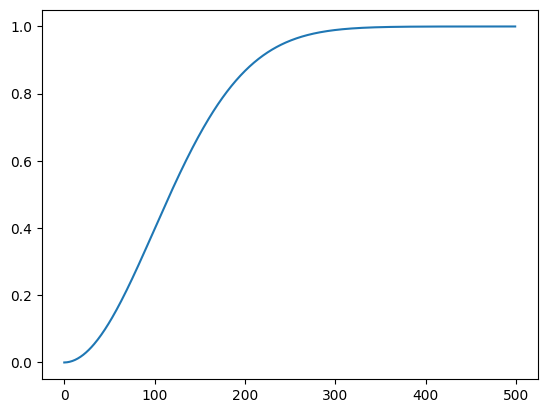

In [ ]:
plt.plot(jnp.arange(0, 500), 1 - alpha_bar1)